In [1]:
import xarray as xr
import pandas as pd
from prophet import Prophet
import cftime
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

# Extracting data and taking a point in Christchurch

In [2]:
# Load your NETCDF file
ds = xr.open_dataset('ECMWF_ERA-40_subset.nc')

# Inspect your dataset
print(ds)

<xarray.Dataset> Size: 89MB
Dimensions:    (longitude: 144, latitude: 73, time: 62)
Coordinates:
  * longitude  (longitude) float32 576B 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * latitude   (latitude) float32 292B 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 496B 2002-07-01T12:00:00 ... 2002-07-31T...
Data variables: (12/17)
    tcw        (time, latitude, longitude) float64 5MB ...
    tcwv       (time, latitude, longitude) float64 5MB ...
    lsp        (time, latitude, longitude) float64 5MB ...
    cp         (time, latitude, longitude) float64 5MB ...
    msl        (time, latitude, longitude) float64 5MB ...
    blh        (time, latitude, longitude) float64 5MB ...
    ...         ...
    e          (time, latitude, longitude) float64 5MB ...
    lcc        (time, latitude, longitude) float64 5MB ...
    mcc        (time, latitude, longitude) float64 5MB ...
    hcc        (time, latitude, longitude) float64 5MB ...
    tco3       (time, latitud

In [3]:
df = ds.to_dataframe()
print(df)


                                              tcw       tcwv       lsp   cp  \
longitude latitude time                                                       
0.0        90.0    2002-07-01 12:00:00  10.152713  10.103384       NaN  NaN   
                   2002-07-01 18:00:00        NaN        NaN  0.000076  0.0   
                   2002-07-02 12:00:00  10.667101  10.623612       NaN  NaN   
                   2002-07-02 18:00:00        NaN        NaN  0.000110  0.0   
                   2002-07-03 12:00:00  11.292196  11.102699       NaN  NaN   
...                                           ...        ...       ...  ...   
357.5     -90.0    2002-07-29 18:00:00        NaN        NaN  0.000035  0.0   
                   2002-07-30 12:00:00   0.237592   0.228353       NaN  NaN   
                   2002-07-30 18:00:00        NaN        NaN  0.000104  0.0   
                   2002-07-31 12:00:00   0.201140   0.196502       NaN  NaN   
                   2002-07-31 18:00:00        NaN   

In [7]:
target_lat = -43.539296
target_lon = 172.63514

point_ds = ds.sel(latitude=target_lat, longitude=target_lon, method='nearest')

print(f"Selected point at Latitude: {point_ds['latitude'].values}°N, Longitude: {point_ds['longitude'].values}°E")
print("\nNew Dataset (unidimensional time series for this point):")
print(point_ds)


Selected point at Latitude: -42.5°N, Longitude: 172.5°E

New Dataset (unidimensional time series for this point):
<xarray.Dataset> Size: 9kB
Dimensions:    (time: 62)
Coordinates:
    longitude  float32 4B 172.5
    latitude   float32 4B -42.5
  * time       (time) datetime64[ns] 496B 2002-07-01T12:00:00 ... 2002-07-31T...
Data variables: (12/17)
    tcw        (time) float64 496B 11.11 nan 9.784 nan ... 9.646 nan 7.426 nan
    tcwv       (time) float64 496B 11.06 nan 9.729 nan ... 9.619 nan 7.413 nan
    lsp        (time) float64 496B nan 0.0001743 nan 0.0 nan ... nan 0.0 nan 0.0
    cp         (time) float64 496B nan 0.0 nan 0.0 nan ... 0.0 nan 0.0 nan 0.0
    msl        (time) float64 496B 9.9e+04 nan 9.945e+04 ... nan 1.032e+05 nan
    blh        (time) float64 496B nan 1.457e+03 nan ... 254.2 nan 852.4
    ...         ...
    e          (time) float64 496B nan -7.151e-05 nan ... nan 3.679e-05
    lcc        (time) float64 496B nan 0.631 nan 0.6502 ... nan 0.47 nan 0.1984
    mcc  

In [5]:
# Target variable
tp_series = point_ds['tp'].to_series().rename('y')

# Regressor variables
# List all variables you want as features (excluding 'tp' which is 'y')
feature_variables = [
    'tcw', 'tcwv', 'lsp', 'cp', 'msl', 'blh',
    'e', 'lcc', 'mcc', 'hcc', 'tco3' # Exclude 'tp' as it's the target
]


In [6]:
# Create a dictionary to hold all series
series_dict = {'ds': tp_series.index, 'y': tp_series.values}

for var_name in feature_variables:
    if var_name in point_ds.data_vars: # Check if the variable actually exists in the dataset
        series_dict[var_name] = point_ds[var_name].to_series().values
    else:
        print(f"Warning: Variable '{var_name}' not found at the selected point, skipping.")



In [7]:
# Create the Prophet-ready DataFrame
prophet_df = pd.DataFrame(series_dict)

# Ensure 'ds' is datetime type (xarray's to_series usually handles this, but good practice)
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])


In [8]:
print("\nProphet-ready DataFrame head:")
print(prophet_df.head())
print("\nProphet-ready DataFrame info:")
print(prophet_df.info())



Prophet-ready DataFrame head:
                   ds         y        tcw       tcwv       lsp   cp  \
0 2002-07-01 12:00:00       NaN  11.113983  11.060231       NaN  NaN   
1 2002-07-01 18:00:00  0.000175        NaN        NaN  0.000174  0.0   
2 2002-07-02 12:00:00       NaN   9.784137   9.729139       NaN  NaN   
3 2002-07-02 18:00:00  0.000000        NaN        NaN  0.000000  0.0   
4 2002-07-03 12:00:00       NaN  10.661700  10.594415       NaN  NaN   

             msl          blh         e       lcc       mcc           hcc  \
0   98998.131146          NaN       NaN       NaN       NaN           NaN   
1            NaN  1457.119973 -0.000072  0.631035  0.414362  2.053958e-02   
2   99454.568200          NaN       NaN       NaN       NaN           NaN   
3            NaN  1331.417246  0.000096  0.650171  0.057804  1.000089e-12   
4  100050.295173          NaN       NaN       NaN       NaN           NaN   

       tco3  
0  0.008298  
1       NaN  
2  0.008222  
3       NaN  
4  

# Addressing NaNs in the data

In [9]:
print("\nNaN counts per column in Prophet-ready DataFrame:")
print(prophet_df.isnull().sum())


NaN counts per column in Prophet-ready DataFrame:
ds       0
y       31
tcw     31
tcwv    31
lsp     31
cp      31
msl     31
blh     31
e       31
lcc     31
mcc     31
hcc     31
tco3    31
dtype: int64


In [10]:
# 1. Separate the variables by their primary timestep
daily_12z_vars = ['tcw', 'tcwv', 'msl', 'tco3']
daily_18z_vars = ['y', 'lsp', 'cp', 'blh', 'e', 'lcc', 'mcc', 'hcc']

# Filter rows based on time and keep only columns that should have data at that time
df_12z = prophet_df[prophet_df['ds'].dt.hour == 12][['ds'] + [col for col in daily_12z_vars if col in prophet_df.columns]].copy()
df_18z = prophet_df[prophet_df['ds'].dt.hour == 18][['ds'] + [col for col in daily_18z_vars if col in prophet_df.columns]].copy()

# Rename 'ds' column temporarily to avoid collision during merge before setting as index
df_12z = df_12z.rename(columns={'ds': 'ds_12z'})
df_18z = df_18z.rename(columns={'ds': 'ds_18z'})


# Sum 'tp', 'lsp', 'cp', 'e' if they are accumulations across different timesteps
# (This logic depends on precise ERA-40 documentation for these variables.
# For simplicity, if 18:00 is the *only* daily report of accumulated, we take it directly.
# If there were 00:00 values, you'd need to sum 00:00 and 18:00 for a daily total).
# For now, let's assume 'y' at 18:00 is the full daily value.

# Create a common date column for merging
df_12z['date_key'] = df_12z['ds_12z'].dt.date
df_18z['date_key'] = df_18z['ds_18z'].dt.date


# Merge the two dataframes on the date key.
# Use an outer merge to keep all dates from both 12Z and 18Z data
final_prophet_df = pd.merge(df_12z, df_18z, on='date_key', how='outer', suffixes=('_12z', '_18z'))

# Consolidate the 'ds' column. Prioritize 12Z if present, else use 18Z, otherwise NaN
final_prophet_df['ds'] = final_prophet_df['ds_12z'].fillna(final_prophet_df['ds_18z'])

# Drop the temporary 'ds_12z', 'ds_18z', and 'date_key' columns
final_prophet_df.drop(columns=['ds_12z', 'ds_18z', 'date_key'], inplace=True)

# Rename the 'y_18z' to 'y'
final_prophet_df.rename(columns={'y_18z': 'y'}, inplace=True)

# Reorder columns for clarity (ds, y, then features)
# Get all column names that are not 'ds' or 'y'
feature_cols = [col for col in final_prophet_df.columns if col not in ['ds', 'y']]
final_prophet_df = final_prophet_df[['ds', 'y'] + feature_cols]

# Sort by 'ds' to ensure correct time series order
final_prophet_df.sort_values('ds', inplace=True)
final_prophet_df.reset_index(drop=True, inplace=True)

print("\nDataFrame after initial daily consolidation and before final NaN handling:")
print(final_prophet_df)
print("\nNaN counts before final handling:")
print(final_prophet_df.isnull().sum())


# --- Final NaN Handling (Corrected to use DatetimeIndex) ---

# First, ensure 'ds' is datetime
final_prophet_df['ds'] = pd.to_datetime(final_prophet_df['ds'])

# Drop rows where 'y' is NaN (Prophet requires this)
# Do this before setting index if you want to keep 'ds' as a column after reset_index()
final_prophet_df.dropna(subset=['y'], inplace=True)
print(f"\nDataFrame shape after dropping rows with NaN in 'y': {final_prophet_df.shape}")

# Now, set 'ds' as the index for time-based interpolation
final_prophet_df.set_index('ds', inplace=True)

# Select only the feature columns for interpolation
cols_to_impute = [col for col in final_prophet_df.columns if col != 'y'] # 'y' is handled, 'ds' is index

if not final_prophet_df[cols_to_impute].empty:
    print(f"\nImputing NaNs in columns: {cols_to_impute}")
    # Interpolate for time series data using the DatetimeIndex
    final_prophet_df[cols_to_impute] = final_prophet_df[cols_to_impute].interpolate(method='time', axis=0)

    # Fill any remaining NaNs (e.g., if interpolation can't fill first/last values)
    # Apply ffill and then bfill
    final_prophet_df[cols_to_impute] = final_prophet_df[cols_to_impute].fillna(method='ffill').fillna(method='bfill')

# Reset the index back to a column named 'ds' for Prophet's fit method
final_prophet_df.reset_index(inplace=True)

print("\nProphet-ready DataFrame (after all NaN handling and reset_index):")
print(final_prophet_df.head())
print("\nNaN counts after all handling:")
print(final_prophet_df.isnull().sum())
print("\nFinal DataFrame Info:")
print(final_prophet_df.info())



DataFrame after initial daily consolidation and before final NaN handling:
                    ds         y        tcw       tcwv            msl  \
0  2002-07-01 12:00:00  0.000175  11.113983  11.060231   98998.131146   
1  2002-07-02 12:00:00  0.000000   9.784137   9.729139   99454.568200   
2  2002-07-03 12:00:00  0.000308  10.661700  10.594415  100050.295173   
3  2002-07-04 12:00:00  0.000000   7.448467   7.417312   99608.665206   
4  2002-07-05 12:00:00  0.000000  11.319198  11.292475   99550.297736   
5  2002-07-06 12:00:00  0.000220   8.648704   8.502888   99504.326898   
6  2002-07-07 12:00:00  0.000000   7.938552   7.881801   99327.330560   
7  2002-07-08 12:00:00  0.000000   8.952476   8.931545  100030.667174   
8  2002-07-09 12:00:00  0.000000   7.860247   7.839333  100758.280523   
9  2002-07-10 12:00:00  0.000076  15.380294  15.324238  100931.316826   
10 2002-07-11 12:00:00  0.000771  17.378439  16.887574  101235.895154   
11 2002-07-12 12:00:00  0.000241   7.723887   7.

/var/folders/sc/3q0dn98n3650g9d83vqnmpzs5hfw1p/T/ipykernel_68579/2167268576.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_prophet_df[cols_to_impute] = final_prophet_df[cols_to_impute].fillna(method='ffill').fillna(method='bfill')


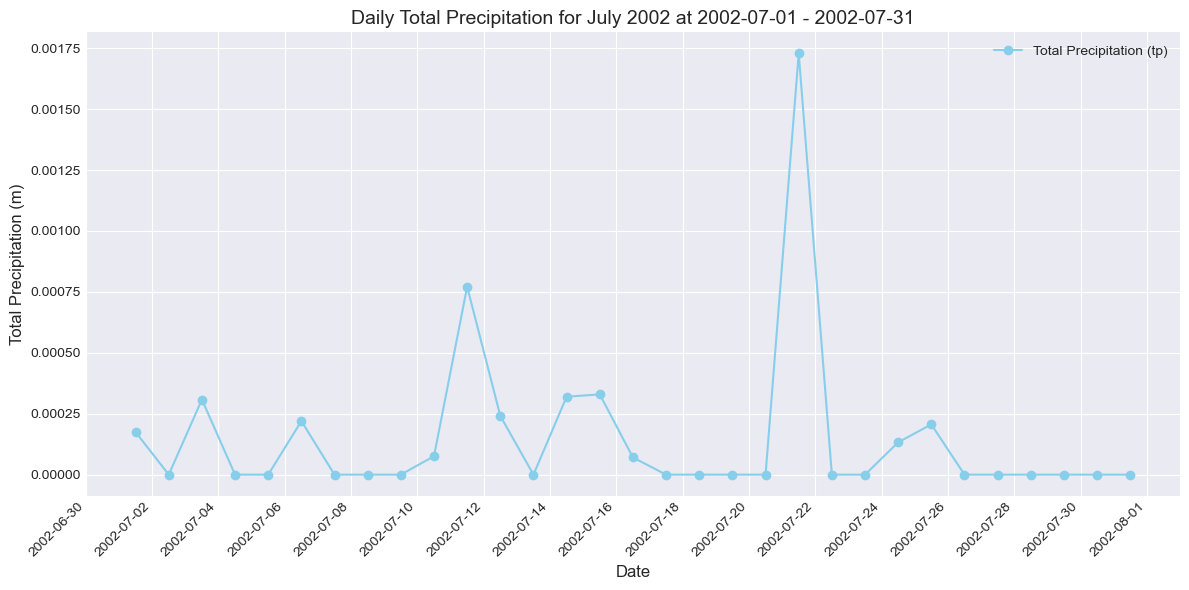

In [11]:
# Ensure your final_prophet_df is loaded or generated from previous steps
# For demonstration, assuming final_prophet_df is ready with 'ds' and 'y' (tp)

# Set a style for better aesthetics (optional)
plt.style.use('seaborn-v0_8-darkgrid') # Using seaborn style for a clean look

plt.figure(figsize=(12, 6)) # Set the figure size for better readability

# Plotting the 'y' (tp) time series
plt.plot(final_prophet_df['ds'], final_prophet_df['y'],
         marker='o',    # Add markers at each data point
         linestyle='-', # Connect points with a line
         color='skyblue', # Choose a nice color
         label='Total Precipitation (tp)' # Label for the legend
        )

# Add labels and title
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Precipitation (m)', fontsize=12) # Assuming units are meters
plt.title(f'Daily Total Precipitation for July 2002 at {final_prophet_df["ds"].dt.date.min()} - {final_prophet_df["ds"].dt.date.max()}', fontsize=14)

# Customize x-axis ticks for better readability of dates
# This helps prevent overlapping dates on the x-axis for daily data
plt.xticks(rotation=45, ha='right') # Rotate labels for better fit
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=2)) # Show every 2nd day, adjust as needed

plt.legend(fontsize=10) # Display the legend
plt.grid(True) # Ensure grid is visible

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show() # Display the plot

# Train/test split

In [12]:
#SETTING THE INDEX AS DATETIME
final_prophet_df_indexed = final_prophet_df.set_index('ds')


split_date = '2002-07-25'
train_df = final_prophet_df_indexed.loc[final_prophet_df_indexed.index <= split_date].copy()
test_df = final_prophet_df_indexed.loc[final_prophet_df_indexed.index > split_date].copy()

#RESETTING INDEX
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

print(f"Train set starts: {train_df['ds'].min()} and ends: {train_df['ds'].max()}")
print(f"Test set starts: {test_df['ds'].min()} and ends: {test_df['ds'].max()}")
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

print("\nTrain DataFrame head (ready for Prophet):")
print(train_df.head())
print("\nTest DataFrame head (ready for Prophet evaluation):")
print(test_df.head())



Train set starts: 2002-07-01 12:00:00 and ends: 2002-07-24 12:00:00
Test set starts: 2002-07-25 12:00:00 and ends: 2002-07-31 12:00:00
Train set shape: (24, 13)
Test set shape: (7, 13)

Train DataFrame head (ready for Prophet):
                   ds         y        tcw       tcwv            msl  \
0 2002-07-01 12:00:00  0.000175  11.113983  11.060231   98998.131146   
1 2002-07-02 12:00:00  0.000000   9.784137   9.729139   99454.568200   
2 2002-07-03 12:00:00  0.000308  10.661700  10.594415  100050.295173   
3 2002-07-04 12:00:00  0.000000   7.448467   7.417312   99608.665206   
4 2002-07-05 12:00:00  0.000000  11.319198  11.292475   99550.297736   

       tco3       lsp   cp          blh         e       lcc       mcc  \
0  0.008298  0.000174  0.0  1457.119973 -0.000072  0.631035  0.414362   
1  0.008222  0.000000  0.0  1331.417246  0.000096  0.650171  0.057804   
2  0.007365  0.000308  0.0   784.566887  0.000009  0.499145  0.252564   
3  0.007748  0.000000  0.0   414.635505  0.0000

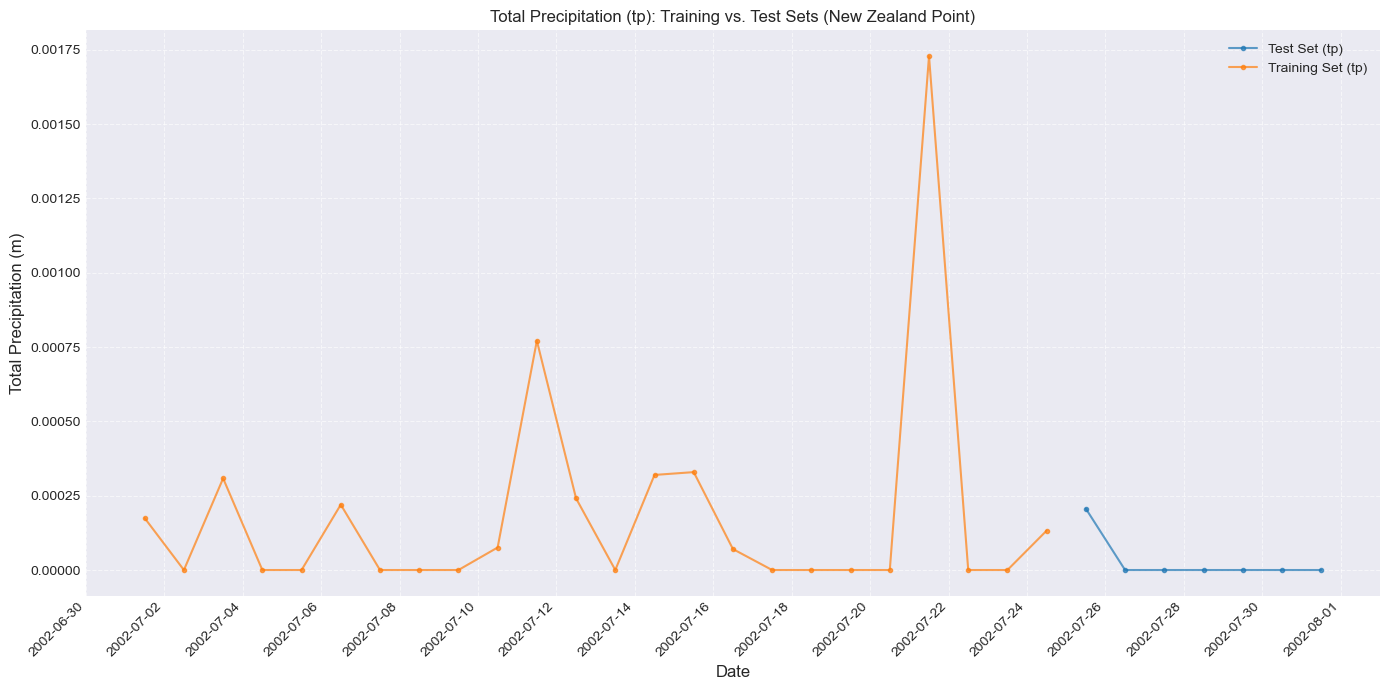

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume final_prophet_df, train_df, test_df are ready from previous steps.

# --- IMPORTANT: Re-set 'ds' as index for plotting join ---
# This ensures the .join() method can align on the datetime values
# We're creating temporary DataFrames for plotting, so no need to modify original train_df/test_df
train_plot_data = train_df.set_index('ds')[['y']].copy() # Select ONLY the 'y' column
test_plot_data = test_df.set_index('ds')[['y']].copy()   # Select ONLY the 'y' column

# Rename the 'y' column for clarity in the plot legend
train_plot_data = train_plot_data.rename(columns={'y': 'Training Set (tp)'})
test_plot_data = test_plot_data.rename(columns={'y': 'Test Set (tp)'})

# Join them on their (Datetime)Index. Now there's no overlap in other columns.
# Use 'outer' to include all time points from both sets
combined_df_for_plot = test_plot_data.join(
    train_plot_data,
    how='outer'
)

# Plot the combined DataFrame
plt.figure(figsize=(14, 7)) # Adjust figsize as needed
combined_df_for_plot.plot(
    ax=plt.gca(), # Use current axes
    figsize=(14, 7),
    title='Total Precipitation (tp): Training vs. Test Sets (New Zealand Point)',
    marker='o',    # Keep markers to highlight individual daily points
    linestyle='-', # Add lines to connect the points
    ms=3,          # Marker size
    alpha=0.7      # Transparency for overlapping points
)

# Customize x-axis for better date visibility
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Precipitation (m)', fontsize=12) # Assuming units are meters
plt.xticks(rotation=45, ha='right')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator(interval=2)) # Adjust interval as needed

plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Training

In [15]:
train_df = train_df.reset_index()

In [25]:
regressor_cols = [col for col in train_df.columns if col not in ['ds', 'y', 'index']]
print(f"\nIdentified regressors: {regressor_cols}")



Identified regressors: ['tcw', 'tcwv', 'msl', 'tco3', 'lsp', 'cp', 'blh', 'e', 'lcc', 'mcc', 'hcc']


In [26]:
model = Prophet()

for regressor in regressor_cols:
    model.add_regressor(regressor)


In [27]:
print("\nFitting Prophet model with regressors...")
model.fit(train_df)
print("Model fitting complete.")


16:36:51 - cmdstanpy - INFO - Chain [1] start processing



Fitting Prophet model with regressors...


16:36:57 - cmdstanpy - INFO - Chain [1] done processing


Model fitting complete.


# Prediction

In [29]:
print(f"Columns in train_df: {train_df.columns.tolist()}")
print(f"Columns in test_df: {test_df.columns.tolist()}")
print(f"Regressor columns chosen: {regressor_cols}")


future = pd.concat([train_df[['ds'] + regressor_cols], test_df[['ds'] + regressor_cols]])
future['ds'] = pd.to_datetime(future['ds'])

print("\nFuture DataFrame head (for prediction, should not contain 'index'):\n", future.head())
print("\nFuture DataFrame tail (for prediction, should not contain 'index'):\n", future.tail())
print(f"\nFuture DataFrame shape: {future.shape}")

# --- 7. Make predictions ---
print("\nMaking predictions...")
forecast = model.predict(future)
print("Prediction complete.")


Columns in train_df: ['index', 'ds', 'y', 'tcw', 'tcwv', 'msl', 'tco3', 'lsp', 'cp', 'blh', 'e', 'lcc', 'mcc', 'hcc']
Columns in test_df: ['ds', 'y', 'tcw', 'tcwv', 'msl', 'tco3', 'lsp', 'cp', 'blh', 'e', 'lcc', 'mcc', 'hcc']
Regressor columns chosen: ['tcw', 'tcwv', 'msl', 'tco3', 'lsp', 'cp', 'blh', 'e', 'lcc', 'mcc', 'hcc']

Future DataFrame head (for prediction, should not contain 'index'):
                    ds        tcw       tcwv            msl      tco3  \
0 2002-07-01 12:00:00  11.113983  11.060231   98998.131146  0.008298   
1 2002-07-02 12:00:00   9.784137   9.729139   99454.568200  0.008222   
2 2002-07-03 12:00:00  10.661700  10.594415  100050.295173  0.007365   
3 2002-07-04 12:00:00   7.448467   7.417312   99608.665206  0.007748   
4 2002-07-05 12:00:00  11.319198  11.292475   99550.297736  0.007698   

        lsp   cp          blh         e       lcc       mcc           hcc  
0  0.000174  0.0  1457.119973 -0.000072  0.631035  0.414362  2.053958e-02  
1  0.000000  0.0

/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


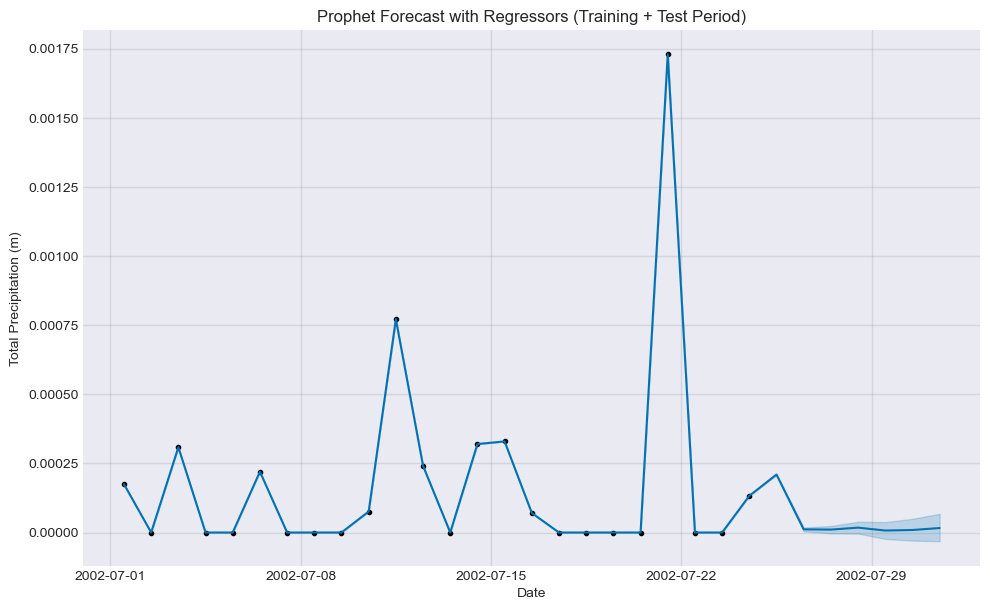

In [31]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast with Regressors (Training + Test Period)')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (m)')
plt.show()


/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/ahmed.shaikh/miniforge3/envs/srsi/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


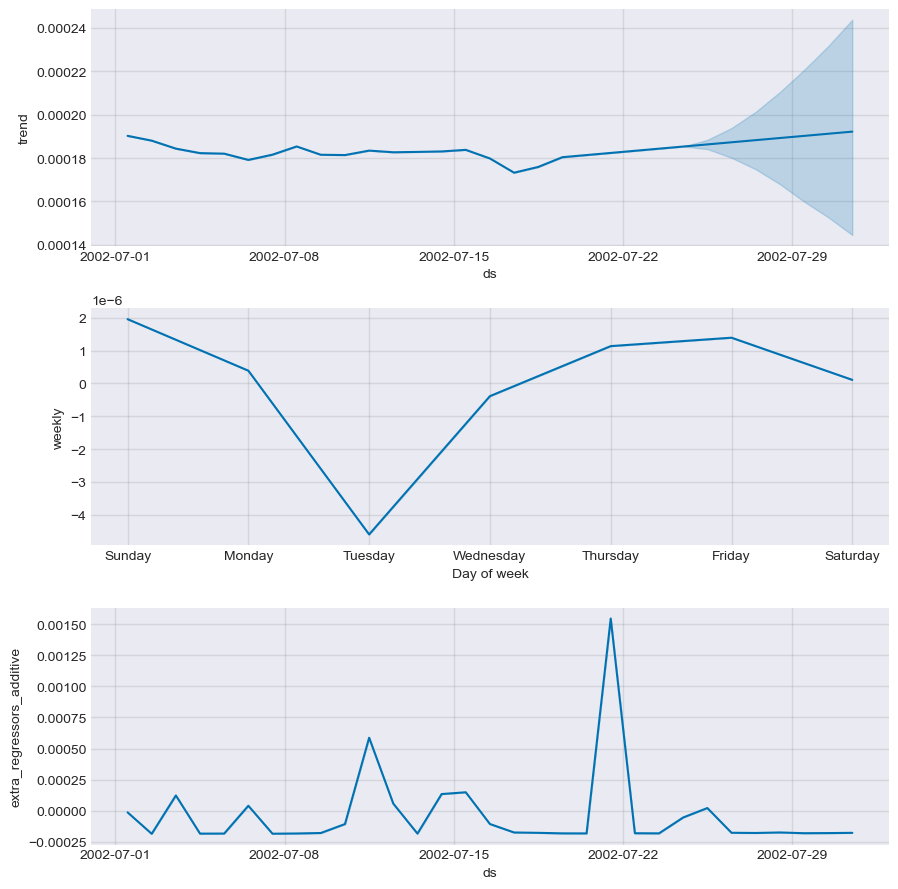

In [33]:
fig2 = model.plot_components(forecast)
plt.show()


In [34]:
forecast_test = forecast[forecast['ds'].isin(test_df['ds'])]


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual_vs_forecast = pd.merge(
    test_df[['ds', 'y']],
    forecast_test[['ds', 'yhat']],
    on='ds',
    how='inner'
)

mae = mean_absolute_error(actual_vs_forecast['y'], actual_vs_forecast['yhat'])
rmse = np.sqrt(mean_squared_error(actual_vs_forecast['y'], actual_vs_forecast['yhat']))

print(f"\n--- Evaluation Metrics on Test Set ---")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")




--- Evaluation Metrics on Test Set ---
Mean Absolute Error (MAE): 0.000011
Root Mean Squared Error (RMSE): 0.000012


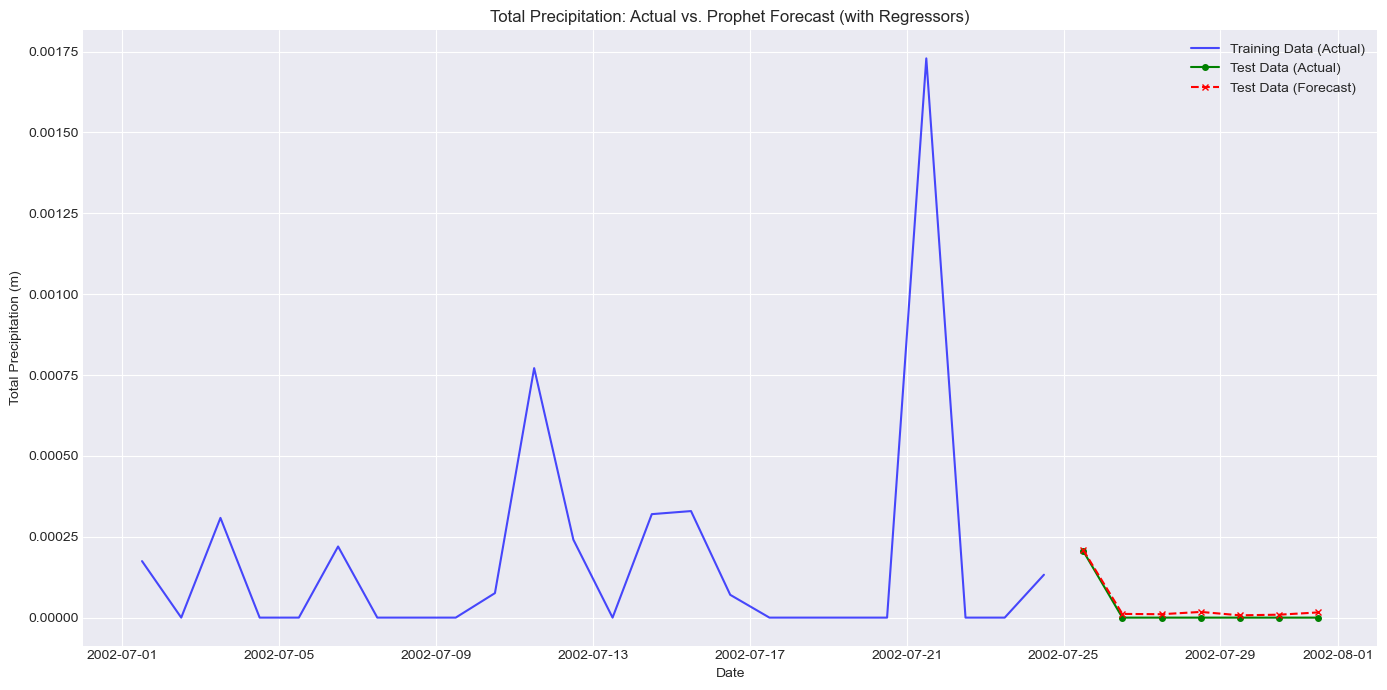

In [40]:
# --- 10. Visualize Actual vs. Predicted on Test Set ---
plt.figure(figsize=(14, 7))
plt.plot(train_df['ds'], train_df['y'], label='Training Data (Actual)', color='blue', alpha=0.7)
plt.plot(actual_vs_forecast['ds'], actual_vs_forecast['y'], label='Test Data (Actual)', color='green', marker='o', linestyle='-', markersize=4)
plt.plot(actual_vs_forecast['ds'], actual_vs_forecast['yhat'], label='Test Data (Forecast)', color='red', linestyle='--', marker='x', markersize=4)

plt.title('Total Precipitation: Actual vs. Prophet Forecast (with Regressors)')
plt.xlabel('Date')
plt.ylabel('Total Precipitation (m)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
